# 08 Example - Optimization Scan Using Gradient Descent Implemented from AbstractScanOptimizer

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

## Setup devices

In [ ]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define a measure function

In [ ]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

# Define live plot

In [ ]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

# Define runinfo

In [4]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

# Define a scan optimizer class

In [ ]:
class GradientDescentOptimizeScan(ps.AbstractOptimizeScan):

    def __init__(self, initialization_dict, prop, optimizer_inputs, sample_function_output,
                 input_init, input_epsilon, learning_rate, update_epsilon, iteration_max=100, dt=0):
        super().__init__(self, initialization_dict, prop, optimizer_inputs, sample_function_output, iteration_max=100, dt=0)
        self.dim = 0
        self.fd_step = True
        self.input_init = input_init
        self.input_epsilon = input_epsilon
        self.learning_rate = learning_rate
        self.update_epsilon = update_epsilon
        self.dim_ct = len(self.input_init)
        self.keep_running = np.full(self.dim_ct, True)
    
    def step_optimizer(self, index, experiment):
        
        def gd_f(f_in_prev, f_out, f_out_prev, input_epsilon, learning_rate):
            grad = (f_out - f_out_prev) / input_epsilon
            grad_update = learning_rate * grad
            f_in_dim_next = f_in_prev - grad_update
            return grad, f_in_dim_next

        if self.fd_step:
            f_in = [experiment.__dict__[measurement][index - 1] for measurement in self.opt_in]
            f_in[self.dim] += self.input_epsilon
            self.fd_step = False
            return f_in
        else:
            f_in_prev = [experiment.__dict__[measurement][index - 2] for measurement in self.opt_in]
            f_out = experiment.__dict__[self.sample_f_out][index - 1]
            f_out_prev = experiment.__dict__[self.sample_f_out][index - 2]
            grad_dim, f_in_next_dim = gd_f(f_in_prev[self.dim], f_out, f_out_prev, self.input_epsilon[self.dim], self.learning_rate[self.dim])
            f_in_next = f_in_prev.copy()
            f_in_next[self.dim] = f_in_next_dim
            self.keep_running[self.dim] = abs(grad_dim) > self.update_epsilon[self.dim]
            if not self.keep_running.any():
                experiment.runinfo.running = False
            self.fd_step = True
            self.dim += 1
            self.dim %= self.dim_ct
            return f_in_next


# Define Experiments

In [ ]:
runinfo.scan0 = GradientDescentOptimizeScan({'v1': 1., 'v2': 2.}, 'voltage', ['v1_readout', 'v2_readout'], 'vf',
                                iteration_max=30)

# Run Experiments

In [8]:
expt = ps.Experiment(runinfo, devices, time=True)
expt.start_thread()

In [9]:
sleep(1) # wait for thread to finish

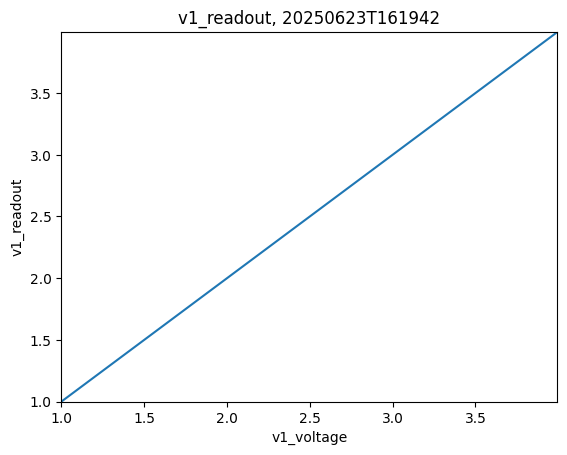

In [10]:
ps.live_plot1D(expt, data_name="v1_readout")

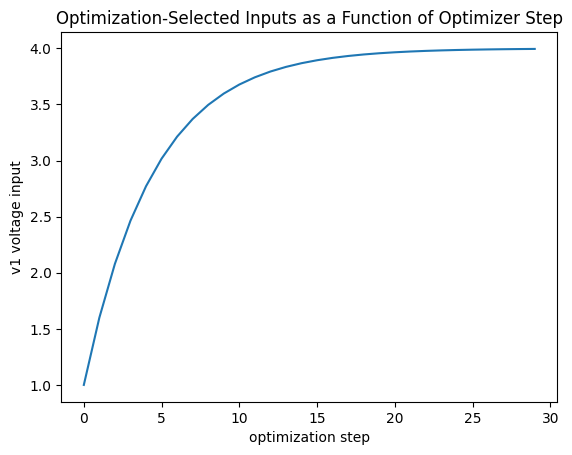

In [11]:
plt.plot(expt.v1_voltage)
plt.xlabel("optimization step")
plt.ylabel("v1 voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

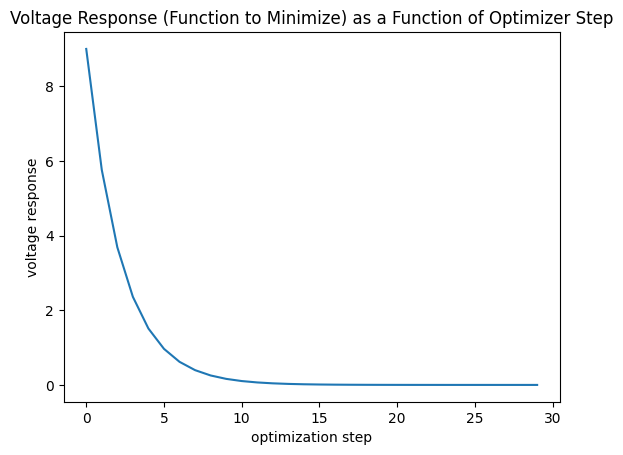

In [12]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

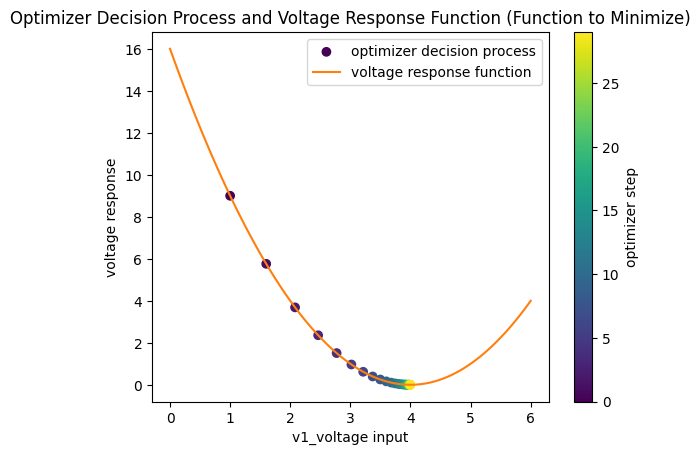

In [13]:
plt.scatter(expt.v1_voltage, expt.vf, c=range(len(expt.v1_voltage)))
plt.plot(*zip(*[(v, voltage_response(v)) for v in np.linspace(0, 6, 100)]), color='C1')
plt.colorbar(label="optimizer step")
plt.legend(["optimizer decision process", "voltage response function"])
plt.xlabel("v1_voltage input")
plt.ylabel("voltage response")
plt.title("Optimizer Decision Process and Voltage Response Function (Function to Minimize)");